# Part 16

# Using Code Interpreter

Universal code for the entire notebook

In [1]:
# Uncomment the line below to make sure you have all the packages needed
# %pip install -r requirements.txt

In [2]:
# Standard library imports
import time  # Used for time-related functions
import threading  # Used for creating and managing threads

# Third-party library imports
from openai import OpenAI  # Used for interacting with OpenAI's API
from openai import AssistantEventHandler  # Used for handling events related to OpenAI assistants
from typing_extensions import override  # Used for overriding methods in subclasses
from IPython.display import display, Markdown, clear_output  # Used for displaying content in Jupyter Notebooks

import base64  # Used for encoding and decoding binary data
import requests  # Used for making HTTP requests
import markdown2  # Used for converting Markdown to HTML
from IPython.display import display, HTML  # Used for displaying HTML content in Jupyter Notebooks


In [3]:
# Create an instance of the OpenAI class to interact with the API.
# This assumes you have set the OPENAI_API_KEY environment variable.
client = OpenAI() 

In [4]:
# Create our custom event handler class that inherits from AssistantEventHandler for streaming assistant output.
class EventHandler(AssistantEventHandler):
    """Custom event handler for processing assistant events."""

    def __init__(self):
        super().__init__()
        self.results = []  # Initialize the results list

    @override
    def on_text_created(self, text) -> None:
        """Handle the event when text is first created."""
        # Print the created text to the console
        print("\nassistant text > ", end="", flush=True)
        # Append the created text to the results list
        self.results.append(text)

    @override
    def on_text_delta(self, delta, snapshot):
        """Handle the event when there is a text delta (partial text)."""
        # Print the delta value (partial text) to the console
        print(delta.value, end="", flush=True)
        # Append the delta value to the results list
        self.results.append(delta.value)

    def on_tool_call_created(self, tool_call):
        """Handle the event when a tool call is created."""
        # Print the type of the tool call to the console
        print(f"\nassistant tool > {tool_call.type}\n", flush=True)

    def on_tool_call_delta(self, delta, snapshot):
        """Handle the event when there is a delta (update) in a tool call."""
        if delta.type == 'code_interpreter':
            # Check if there is an input in the code interpreter delta
            if delta.code_interpreter.input:
                # Print the input to the console
                print(delta.code_interpreter.input, end="", flush=True)
                # Append the input to the results list
                self.results.append(delta.code_interpreter.input)
            # Check if there are outputs in the code interpreter delta
            if delta.code_interpreter.outputs:
                # Print a label for outputs to the console
                print("\n\noutput >", flush=True)
                # Iterate over each output and handle logs specifically
                for output in delta.code_interpreter.outputs or []:
                    if output.type == "logs":
                        # Print the logs to the console
                        print(f"\n{output.logs}", flush=True)
                        # Append the logs to the results list
                        self.results.append(output.logs)


## Creating an Assistant with Code Interpreter Enabled

Our first step is to create an Assistant that can use Code Interpreter

In [5]:
# Create an assistant using the client library.
assistant = client.beta.assistants.create(
    model="gpt-4o",  # Specify the model to be used.
    
    instructions=""" 
        You are a helpful assistant.
    """,  # Instructions for the assistant.
    
    name="Code Interpreter Assistant",  # Give the assistant a name.
    
    tools=[{"type": "code_interpreter"}],  # Add the code interpreter capability to the assistant.
    
    metadata={  # Add metadata about the assistant's capabilities.
        "can_be_used_for_code_analysis": "True",
        "can_do_python": "True",
    },
    
    temperature=1,  # Set the temperature for response variability.
    top_p=1,  # Set the top_p for nucleus sampling.
)

# Print the details of the created assistant to check its properties.
print(assistant)  # Print the full assistant object.
print("\n\n")
print(assistant.name)  # Print the name of the assistant.
print(assistant.metadata)  # Print the metadata of the assistant.


Assistant(id='asst_4HcFKfGnueYD8v30AI0kjFfO', created_at=1719384128, description=None, instructions=' \n        You are a helpful assistant.\n    ', metadata={'can_be_used_for_code_analysis': 'True', 'can_do_python': 'True'}, model='gpt-4o', name='Code Interpreter Assistant', object='assistant', tools=[CodeInterpreterTool(type='code_interpreter')], response_format='auto', temperature=1.0, tool_resources=ToolResources(code_interpreter=ToolResourcesCodeInterpreter(file_ids=[]), file_search=None), top_p=1.0)



Code Interpreter Assistant
{'can_be_used_for_code_analysis': 'True', 'can_do_python': 'True'}


## Passing Files to Code Interpreter

There are a variety of ways to get files for Code Interpreter to use. 
- Assistant files - viewable by all runs that use the assistant.
- Thread files - only viewable by runs that use the thread. 

Let's review the code for the two main approaches.

### Getting Files to the Assistant

First, you have to have a file that has been uploaded so we can pass it to our assistant.

In [6]:
# Upload a file with an "assistants" purpose.
assistant_file = client.files.create(
    file=open("./artifacts/penguins_size.csv", "rb"),  # Open the file in binary read mode.
    purpose='assistants'  # Specify the purpose of the file upload.
)

# Print the details of the uploaded file to check its properties.
print(assistant_file)


FileObject(id='file-LKZle4mumAm8VCYCFVavpLQE', bytes=13519, created_at=1719384129, filename='penguins_size.csv', object='file', purpose='assistants', status='processed', status_details=None)


Next, we need to modify our Assistant with the new file information. 

In [7]:
# Update the assistant to add tools and tool resources.
assistant = client.beta.assistants.update(
    assistant_id=assistant.id,  # Use the assistant's ID.
    tools=[{"type": "code_interpreter"}],  # Add the code interpreter capability to the assistant.
    tool_resources={
        "code_interpreter": {
            "file_ids": [assistant_file.id]  # Link the uploaded file to the code interpreter tool.
        }
    }
)

# Print the details of the updated assistant to check its properties.
print(assistant)


Assistant(id='asst_4HcFKfGnueYD8v30AI0kjFfO', created_at=1719384128, description=None, instructions=' \n        You are a helpful assistant.\n    ', metadata={'can_be_used_for_code_analysis': 'True', 'can_do_python': 'True'}, model='gpt-4o', name='Code Interpreter Assistant', object='assistant', tools=[CodeInterpreterTool(type='code_interpreter')], response_format='auto', temperature=1.0, tool_resources=ToolResources(code_interpreter=ToolResourcesCodeInterpreter(file_ids=['file-LKZle4mumAm8VCYCFVavpLQE']), file_search=None), top_p=1.0)


Finally, let's run a message and see if it is working.

In [8]:
# Create a new assistant thread with an initial user message.
assistant_thread = client.beta.threads.create(
    messages=[
        {
            "role": "user",
            "content": "Give me a summary of the file penguins_size.csv."
        },
    ]
)

# Stream the assistant's response to the thread.
with client.beta.threads.runs.stream(
    thread_id=assistant_thread.id,  # Use the thread's ID.
    assistant_id=assistant.id,  # Use the assistant's ID.
    instructions="""
    You are a helpful assistant.
    """,  # Provide instructions to the assistant.
    event_handler=EventHandler(),  # Use the custom event handler for processing events.
) as stream:
    stream.until_done()  # Continue streaming until the assistant has finished responding.



assistant tool > code_interpreter

import pandas as pd

# Load the data
file_path = '/mnt/data/file-LKZle4mumAm8VCYCFVavpLQE'
penguins_data = pd.read_csv(file_path)

# Display basic information about the data
penguins_data_info = penguins_data.info()
penguins_data_head = penguins_data.head()

penguins_data_info, penguins_data_head

output >

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   culmen_length_mm   342 non-null    float64
 3   culmen_depth_mm    342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                334 non-null    object 
dtypes: float64(4), object(3)
memory usage: 18.9+ KB


assistant text > The file `penguins_size.csv` is a dataset that 

## Formatting the Output
What if we want to format the markdown output? There are two ways to do it. The "easy" way is to just let the output render without streaming and format it afterward.

In [9]:
# Create a new assistant thread with an initial user message.
assistant_thread = client.beta.threads.create(
    messages=[
        {
            "role": "user",
            "content": "Give me a summary of the file penguins_size.csv."
        },
    ]
)

# Create and poll a new run for the assistant thread to get the response.
run = client.beta.threads.runs.create_and_poll(
    thread_id=assistant_thread.id,  # Specify the thread ID.
    assistant_id=assistant.id  # Specify the assistant ID.
)

# Retrieve all messages from the thread using the run ID.
messages = list(client.beta.threads.messages.list(
    thread_id=assistant_thread.id,  # Specify the thread ID.
    run_id=run.id  # Specify the run ID.
))

# Extract the content from the first message in the retrieved messages.
message_content = messages[0].content[0].text
annotations = message_content.annotations  # Extract annotations from the message content.
citations = []  # Initialize an empty list to store citations.

# Process each annotation to replace the text with indexed references and gather citations.
for index, annotation in enumerate(annotations):
    # Replace the annotated text with an indexed reference in the message content.
    message_content.value = message_content.value.replace(annotation.text, f"[{index}]")
    # Check if there is a file citation in the annotation.
    file_citation = getattr(annotation, "file_citation", None)
    if file_citation:
        # Retrieve the cited file's details using its file ID.
        cited_file = client.files.retrieve(file_citation.file_id)
        # Append the citation with the indexed reference and file name to the citations list.
        citations.append(f"[{index}] {cited_file.filename}")

# Display the processed message content with indexed references using Markdown.
display(Markdown(message_content.value))


The file `penguins_size.csv` contains information about different penguin species and their physical characteristics. Here's a summary:

### Overview
- **Total Entries:** 344
- **Columns:** 7

### Columns and Data Types
1. **species** (object): Type of penguin species (e.g., Adelie, Chinstrap, Gentoo).
2. **island** (object): Island where the penguin was found (e.g., Biscoe, Dream, Torgersen).
3. **culmen_length_mm** (float64): Length of the culmen (the upper ridge of the bird's bill) in millimeters.
4. **culmen_depth_mm** (float64): Depth of the culmen in millimeters.
5. **flipper_length_mm** (float64): Length of the flipper in millimeters.
6. **body_mass_g** (float64): Body mass in grams.
7. **sex** (object): Sex of the penguin (e.g., MALE, FEMALE).

### Missing Values
- **culmen_length_mm:** 2 missing values
- **culmen_depth_mm:** 2 missing values
- **flipper_length_mm:** 2 missing values
- **body_mass_g:** 2 missing values
- **sex:** 10 missing values

### Descriptive Statistics
#### Numerical Columns
- **culmen_length_mm:**
  - Mean: 43.92 mm
  - Standard Deviation: 5.46 mm
  - Minimum: 32.1 mm
  - Maximum: 59.6 mm

- **culmen_depth_mm:**
  - Mean: 17.15 mm
  - Standard Deviation: 1.97 mm
  - Minimum: 13.1 mm
  - Maximum: 21.5 mm

- **flipper_length_mm:**
  - Mean: 200.92 mm
  - Standard Deviation: 14.06 mm
  - Minimum: 172.0 mm
  - Maximum: 231.0 mm

- **body_mass_g:**
  - Mean: 4201.75 g
  - Standard Deviation: 801.95 g
  - Minimum: 2700 g
  - Maximum: 6300 g

#### Categorical Columns
- **species:**
  - Unique Values: 3 (Adelie, Chinstrap, Gentoo)
  - Most Frequent: Adelie (152 occurrences)

- **island:**
  - Unique Values: 3 (Biscoe, Dream, Torgersen)
  - Most Frequent: Biscoe (168 occurrences)

- **sex:**
  - Unique Values: 3 (MALE, FEMALE)
  - Most Frequent: MALE (168 occurrences)

Would you like any specific analysis or visualization on this dataset?

The "hard"  (but more user-friendly) way is to stream the output and update the display while streaming to show the formatted text. This is what ChatGPT does when you use it. This will require modifying our event handler to be more streamlined, formatting output, and updating our display.

In [10]:
class EventHandler(AssistantEventHandler):
    """Custom event handler for processing assistant events."""

    def __init__(self):
        super().__init__()
        self.results = []  # Initialize an empty list to store the results

    @override
    def on_text_delta(self, delta, snapshot):
        """Handle the event when there is a text delta (partial text)."""
        # Append the delta value (partial text) to the results list
        self.results.append(delta.value)
        # Call the method to update the Jupyter Notebook cell
        self.update_output()

    def update_output(self):
        """Update the Jupyter Notebook cell with the current markdown content."""
        # Clear the current output in the Jupyter Notebook cell
        clear_output(wait=True)
        # Join all the text fragments stored in results to form the complete markdown content
        markdown_content = "".join(self.results)
        # Display the markdown content in the Jupyter Notebook cell
        display(Markdown(markdown_content))

# Create a new assistant thread with an initial user message.
assistant_thread = client.beta.threads.create(
    messages=[
        {
            "role": "user",
            "content": "Give me a summary of the file penguins_size.csv. With at least one small table of data. Make the information well formatted and easy to read."
        },
    ]
)

# Stream the assistant's response to the thread.
with client.beta.threads.runs.stream(
    thread_id=assistant_thread.id,  # Specify the thread ID.
    assistant_id=assistant.id,  # Specify the assistant ID.
    instructions="""
    You are a helpful assistant.
    """,  # Provide instructions to the assistant.
    event_handler=EventHandler(),  # Use the custom event handler for processing events.
) as stream:
    stream.until_done()  # Continue streaming until the assistant has finished responding.


### Summary of `penguins_size.csv`

The dataset contains information about penguins, including their species, island, and measurements such as culmen length, culmen depth, flipper length, and body mass. Below is a summary and a small table of data from the dataset.

**Statistical Summary**

|                   | culmen_length_mm | culmen_depth_mm | flipper_length_mm | body_mass_g  |
|-------------------|:----------------:|:---------------:|:-----------------:|:------------:|
| **Count**         |      342.00      |      342.00     |      342.00       |    342.00    |
| **Mean**          |      43.92       |      17.15      |      200.92       |   4201.75    |
| **Std**           |      5.46        |      1.97       |      14.06        |    801.95    |
| **Min**           |      32.10       |      13.10      |      172.00       |   2700.00    |
| **25%**           |      39.23       |      15.60      |      190.00       |   3550.00    |
| **50%**           |      44.45       |      17.30      |      197.00       |   4050.00    |
| **75%**           |      48.50       |      18.70      |      213.00       |   4750.00    |
| **Max**           |      59.60       |      21.50      |      231.00       |   6300.00    |

**Sample Data Table**

| species | island    | culmen_length_mm | culmen_depth_mm | flipper_length_mm | body_mass_g | sex   |
|---------|-----------|------------------|-----------------|-------------------|-------------|-------|
| Adelie  | Torgersen | 39.1             | 18.7            | 181.0             | 3750.0      | MALE  |
| Adelie  | Torgersen | 39.5             | 17.4            | 186.0             | 3800.0      | FEMALE|
| Adelie  | Torgersen | 40.3             | 18.0            | 195.0             | 3250.0      | FEMALE|
| Adelie  | Torgersen | NaN              | NaN             | NaN               | NaN         | NaN   |
| Adelie  | Torgersen | 36.7             | 19.3            | 193.0             | 3450.0      | FEMALE|

This table provides the first few rows of the dataset for an overview of the structure and data points available.

## Getting Files to the Thread

First, we need a file uploaded.


In [11]:
# Upload a file with an "assistants" purpose.
thread_file = client.files.create(
    file=open("./artifacts/daily-bike-share.csv", "rb"),  # Open the file in binary read mode.
    purpose='assistants'  # Specify the purpose of the file upload.
)

# Print the details of the uploaded file to check its properties.
print(thread_file)


FileObject(id='file-Z2bnDTaFrEwkNZuf8880wIvO', bytes=43599, created_at=1719384178, filename='daily-bike-share.csv', object='file', purpose='assistants', status='processed', status_details=None)


Second, we need a thread to attach the file to

In [12]:
# Create a new thread with an initial user message requesting a summary of the file.
thread = client.beta.threads.create(
    messages=[
        {
            "role": "user",
            "content": "Give me a summary of the daily-bike-share.csv file."
        },
    ]
)

# Print the details of the created thread to check its properties.
print(thread)


Thread(id='thread_GdJL6bU9ouITvO6nSdC4gxYQ', created_at=1719384179, metadata={}, object='thread', tool_resources=ToolResources(code_interpreter=None, file_search=None))


Third, we can update the thread with the file information

In [13]:
# Update the existing thread to add tool resources, specifically linking the uploaded file.
updated_thread = client.beta.threads.update(
    thread_id=thread.id,  # Use the ID of the existing thread.
    tool_resources={
        "code_interpreter": {
            "file_ids": [thread_file.id]  # Link the uploaded file to the code interpreter tool.
        }
    }
)

# Print the details of the updated thread to check its properties.
print(updated_thread)


Thread(id='thread_GdJL6bU9ouITvO6nSdC4gxYQ', created_at=1719384179, metadata={}, object='thread', tool_resources=ToolResources(code_interpreter=ToolResourcesCodeInterpreter(file_ids=['file-Z2bnDTaFrEwkNZuf8880wIvO']), file_search=None))


Finally, let's run it against a new assistant and see the results

In [14]:
# Create an assistant using the client library.
thread_assistant = client.beta.assistants.create(
    model="gpt-4o",  # Specify the model to be used.
    
    instructions=""" 
        You are a helpful assistant.
    """,  # Instructions for the assistant.
    
    name="Code Interpreter Assistant Using Thread Data",  # Give the assistant a name.
    
    tools=[{"type": "code_interpreter"}],  # Add the code interpreter capability to the assistant.
    
    metadata={  # Add metadata about the assistant's capabilities.
        "can_be_used_for_code_analysis": "True",
        "can_do_python": "True",
    },
    temperature=1,  # Set the temperature for response variability.
    top_p=1,  # Set the top_p for nucleus sampling.
)

# Print the details of the created assistant to check its properties.
print(thread_assistant)  # Print the full assistant object.
print("\n\n")
print(thread_assistant.name)  # Print the name of the assistant.
print(thread_assistant.metadata)  # Print the metadata of the assistant.


Assistant(id='asst_c44P8PCdLzb87FTIlvKie9AV', created_at=1719384179, description=None, instructions=' \n        You are a helpful assistant.\n    ', metadata={'can_be_used_for_code_analysis': 'True', 'can_do_python': 'True'}, model='gpt-4o', name='Code Interpreter Assistant Using Thread Data', object='assistant', tools=[CodeInterpreterTool(type='code_interpreter')], response_format='auto', temperature=1.0, tool_resources=ToolResources(code_interpreter=ToolResourcesCodeInterpreter(file_ids=[]), file_search=None), top_p=1.0)



Code Interpreter Assistant Using Thread Data
{'can_be_used_for_code_analysis': 'True', 'can_do_python': 'True'}


In [15]:
# Stream the output from the assistant.
with client.beta.threads.runs.stream(
    thread_id=updated_thread.id,  # Use the ID of the updated thread.
    assistant_id=thread_assistant.id,  # Use the ID of the newly created assistant.
    event_handler=EventHandler(),  # Use the custom event handler to process events.
) as stream:
    stream.until_done()  # Continue streaming until the assistant has finished responding.


The dataset `daily-bike-share.csv` provides information about daily bike rentals. Here is a summary of the data:

### Statistical Summary
1. **Total Records**: 731 (Number of days in this dataset)
2. **Date Information**:
   - **Day**:
     - Average: 15.74
     - Range: 1 to 31
   - **Month**:
     - Average: 6.52
     - Range: 1 to 12
   - **Year**:
     - Data from two years: 2011 and 2012
3. **Season**:
   - Encoded as (1: Winter, 2: Spring, 3: Summer, 4: Fall)
   - Average: 2.50
   - Most common: Spring/Summer
4. **Holiday**:
   - 0 indicates no holiday, 1 indicates a holiday
   - Most days are non-holidays: Approximately 2.87% are holidays
5. **Weekday**:
   - Encoded as (0: Sunday to 6: Saturday)
   - Average: Around mid-week
6. **Working Day**:
   - 0 indicates non-working days, 1 indicates working days
   - About 68.4% of the days are working days
7. **Weather Situation**:
   - Encoded as (1: Clear, 2: Mist, 3: Light Snow/Rain)
   - Average: 1.40
   - Most common: Clear weather
8. **Temperature (temp)**:
   - Normalized temperature (0.059 to 0.862)
   - Average: 0.495
9. **Feels Like Temperature (atemp)**:
   - Normalized (0.079 to 0.841)
   - Average: 0.474
10. **Humidity (hum)**:
    - (0 to 1 scale)
    - Average: 0.628
11. **Wind Speed**:
    - Normalized (0.022 to 0.507)
    - Average: 0.190
12. **Bike Rentals (rentals)**:
    - Average daily rentals: 848
    - Range: 2 to 3410

This data can help in understanding the daily usage patterns of bike rentals and the factors that influence it, such as weather conditions, holidays, and working days.

### Text Results from files in Assistants and Threads

Let's see what happens if we use an assistant with a file and a thread with a file together

In [16]:
# Create a new thread with an initial user message requesting a summary of two files.
super_thread = client.beta.threads.create(
    messages=[
        {
            "role": "user",
            "content": (
                "Give me a summary of the penguins-size.csv and daily-bike-share.csv files. "
                "Make the information well formatted and easy to read."
            )
        },
    ]
)

# Print the details of the created thread to check its properties.
print(super_thread)


Thread(id='thread_j5M9hXOseLIhvjOhjOR5551o', created_at=1719384192, metadata={}, object='thread', tool_resources=ToolResources(code_interpreter=None, file_search=None))


In [17]:
# Update the newly created thread to add tool resources, specifically linking the uploaded file.
super_updated_thread = client.beta.threads.update(
    thread_id=super_thread.id,  # Use the ID of the newly created thread.
    tool_resources={
        "code_interpreter": {
            "file_ids": [thread_file.id]  # Link the uploaded file to the code interpreter tool.
        }
    }
)

# Print the details of the updated thread to check its properties.
print(super_updated_thread)


Thread(id='thread_j5M9hXOseLIhvjOhjOR5551o', created_at=1719384192, metadata={}, object='thread', tool_resources=ToolResources(code_interpreter=ToolResourcesCodeInterpreter(file_ids=['file-Z2bnDTaFrEwkNZuf8880wIvO']), file_search=None))


In [18]:
# Stream the output from the assistant.
with client.beta.threads.runs.stream(
    thread_id=super_updated_thread.id,  # Use the ID of the updated thread.
    assistant_id=assistant.id,  # Use the ID of the assistant.
    event_handler=EventHandler(),  # Use the custom event handler to process events.
) as stream:
    stream.until_done()  # Continue streaming until the assistant has finished responding.


### Penguins Dataset Summary

**Shape**:
- Rows: 344
- Columns: 7

**Columns**:
1. `species`
2. `island`
3. `culmen_length_mm`
4. `culmen_depth_mm`
5. `flipper_length_mm`
6. `body_mass_g`
7. `sex`

**Missing Values**:
- `species`: 0
- `island`: 0
- `culmen_length_mm`: 2
- `culmen_depth_mm`: 2
- `flipper_length_mm`: 2
- `body_mass_g`: 2
- `sex`: 10

**Data Types**:
- `float64`: 4 columns
- `object`: 3 columns

**First 5 Rows**:
|   | species | island | culmen_length_mm | culmen_depth_mm | flipper_length_mm | body_mass_g | sex   |
|---|---------|--------|------------------|-----------------|-------------------|-------------|-------|
| 0 | Adelie  | Torgersen | 39.1            | 18.7            | 181.0             | 3750.0      | MALE  |
| 1 | Adelie  | Torgersen | 39.5            | 17.4            | 186.0             | 3800.0      | FEMALE|
| 2 | Adelie  | Torgersen | 40.3            | 18.0            | 195.0             | 3250.0      | FEMALE|
| 3 | Adelie  | Torgersen | NaN             | NaN             | NaN               | NaN         | NaN   |
| 4 | Adelie  | Torgersen | 36.7            | 19.3            | 193.0             | 3450.0      | FEMALE|

---

### Daily Bike Share Dataset Summary

**Shape**:
- Rows: 731
- Columns: 13

**Columns**:
1. `day`
2. `mnth`
3. `year`
4. `season`
5. `holiday`
6. `weekday`
7. `workingday`
8. `weathersit`
9. `temp`
10. `atemp`
11. `hum`
12. `windspeed`
13. `rentals`

**Missing Values**:
- `day`: 0
- `mnth`: 0
- `year`: 0
- `season`: 0
- `holiday`: 0
- `weekday`: 0
- `workingday`: 0
- `weathersit`: 0
- `temp`: 0
- `atemp`: 0
- `hum`: 0
- `windspeed`: 0
- `rentals`: 0

**Data Types**:
- `float64`: 4 columns
- `int64`: 9 columns

**First 5 Rows**:
|   | day | mnth | year | season | holiday | weekday | workingday | weathersit | temp     | atemp    | hum      | windspeed | rentals |
|---|-----|------|------|--------|---------|---------|------------|------------|----------|----------|----------|-----------|---------|
| 0 | 1   | 1    | 2011 | 1      | 0       | 6       | 0          | 2          | 0.344167 | 0.363625 | 0.805833 | 0.160446  | 331     |
| 1 | 2   | 1    | 2011 | 1      | 0       | 0       | 0          | 2          | 0.363478 | 0.353739 | 0.696087 | 0.248539  | 131     |
| 2 | 3   | 1    | 2011 | 1      | 0       | 1       | 1          | 1          | 0.196364 | 0.189405 | 0.437273 | 0.248309  | 120     |
| 3 | 4   | 1    | 2011 | 1      | 0       | 2       | 1          | 1          | 0.2      | 0.212122 | 0.590435 | 0.160296  | 108     |
| 4 | 5   | 1    | 2011 | 1      | 0       | 3       | 1          | 1          | 0.226957 | 0.22927  | 0.436957 | 0.1869    | 82      |

### Full Results Output

We may also have images produced as well from the Code Interpreter output. Handling this can be tricky and getting it in the right sequence is pretty difficult. Here is some sample code that will assist but I don't pretend to be good at the interface stuff. :)

species,island,culmenlengthmm,culmendepthmm,flipperlengthmm,bodymassg,sex
Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE

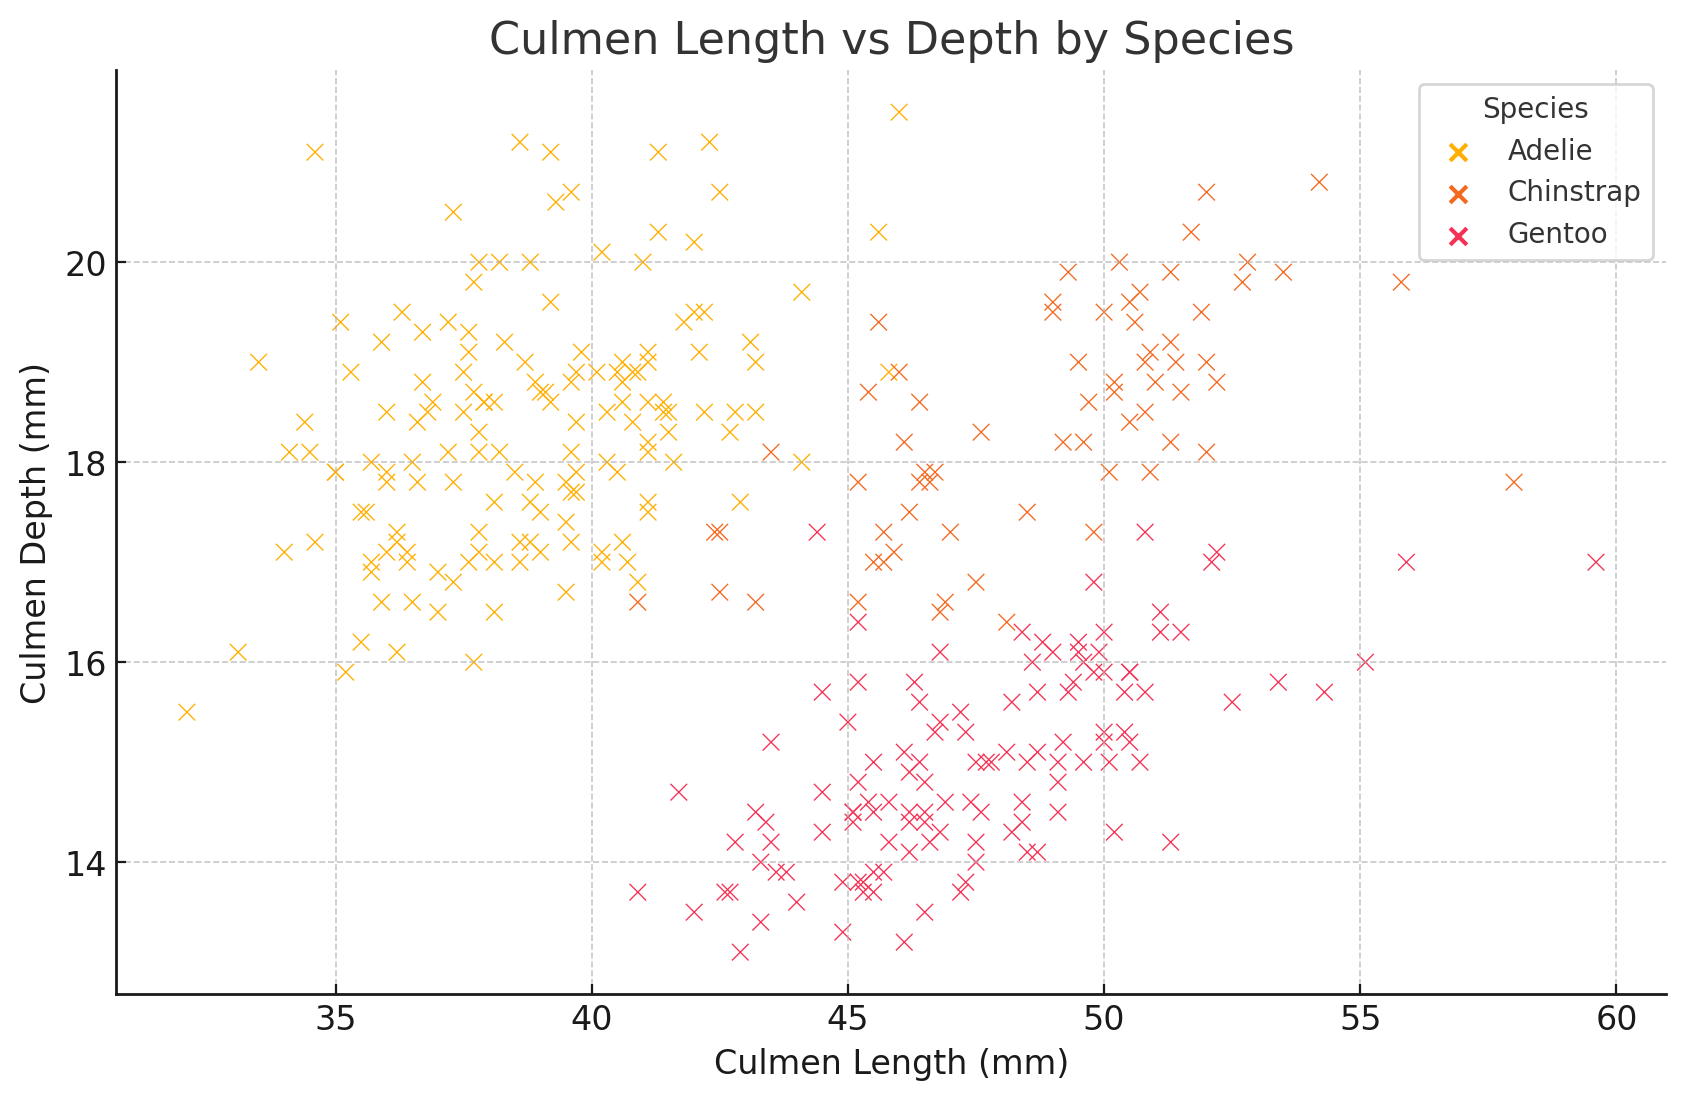

In [19]:

# Create a thread to send a message and get output
assistant_thread = client.beta.threads.create(
    messages=[
        {
            "role": "user",
            "content": "Give me a one paragraph summary of the file penguins_size.csv. With at least one small table of data and one visualization."
        },
    ]
)

run = client.beta.threads.runs.create_and_poll(
    thread_id=assistant_thread.id, assistant_id=assistant.id
)

messages = list(client.beta.threads.messages.list(thread_id=assistant_thread.id, run_id=run.id))

content_blocks = []

# Process each message
for message in messages:
    # Process each content block in the message
    for content_block in message.content:
        if content_block.type == 'text':
            text_content = content_block.text
            annotations = text_content.annotations
            citations = []
            for index, annotation in enumerate(annotations):
                # Replace the text with a footnote
                text_content.value = text_content.value.replace(annotation.text, f' [{index}]')
                # Gather citations based on annotation attributes
                if hasattr(annotation, 'file_citation'):
                    file_citation = annotation.file_citation
                    cited_file = client.files.retrieve(file_citation.file_id)
                    citations.append(f'[{index}] {file_citation.quote} from {cited_file.filename}')
                elif hasattr(annotation, 'file_path'):
                    file_path = annotation.file_path
                    cited_file = client.files.retrieve(file_path.file_id)
                    citations.append(f'[{index}] Click <here> to download {cited_file.filename}')
            # Add footnotes to the end of the message before displaying to user
            text_content.value += '\n' + '\n'.join(citations)
            # Convert Markdown to HTML and append to content_blocks
            content_blocks.append(markdown2.markdown(text_content.value, extras=["tables"]))

        elif content_block.type == 'image_file':
            image_file = content_block.image_file
            file_info = client.files.retrieve(image_file.file_id)
            image_content = client.files.content(file_info.id).content
            image_base64 = base64.b64encode(image_content).decode('utf-8')
            # Append the image HTML to content_blocks
            content_blocks.append(f'<img src="data:image/png;base64,{image_base64}" width="700" height="700"><br>')

# Join all content blocks into a single HTML string
html_content = ''.join(content_blocks)

# Display the combined content
display(HTML(html_content))


### Streaming Formatted Output
I tried everything I could think of to get the images to stream inline with the text but it appears that doing so with Jupyter Notebook cells is very difficult. I finally had to throw in the towel. I did post to the forums to see if anyone had and answer but, apparently, no one did. You can see if someone finally answered here: https://community.openai.com/t/streaming-markdown-text-and-images-from-assistant-using-code-interpreter/823042/9